# Task
Analyze the diabetes dataset using OLS, Ridge, and Lasso regression models. This includes data preparation, scaling, feature analysis, assumption checks, hyperparameter tuning, model evaluation using various metrics, and visual comparison of results and model coefficients to understand the impact of regularization and multicollinearity. The final output should include a summary of findings and insights based on the original features.

## Loadind and Data Preprocessing


In [67]:
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import pandas as pd

# 1. Load the diabetes dataset
diabetes = load_diabetes()

# 2. Separate features (X) and target (y)
X = pd.DataFrame(diabetes.data, columns=diabetes.feature_names)
y = pd.Series(diabetes.target)

# 3. Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Diabetes dataset loaded and split successfully.")

X_train.head()

Diabetes dataset loaded and split successfully.


,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6
17,0.070769,0.050680,0.012117,0.056301,0.034206,0.049416,-0.039719,0.034309,0.027364,-0.001078
66,-0.009147,0.050680,-0.018062,-0.033213,-0.020832,0.012152,-0.072854,0.071210,0.000272,0.019633
137,0.005383,-0.044642,0.049840,0.097615,-0.015328,-0.016345,-0.006584,-0.002592,0.017036,-0.013504
245,-0.027310,-0.044642,-0.035307,-0.029770,-0.056607,-0.058620,0.030232,-0.039493,-0.049872,-0.129483
31,-0.023677,-0.044642,-0.065486,-0.081413,-0.038720,-0.053610,0.059685,-0.076395,-0.037129,-0.042499


In [63]:
# 1. Instantiate StandardScaler
scaler = StandardScaler()

# 2. Fit the scaler to the training features (X_train) and transform them
X_train_scaled = scaler.fit_transform(X_train)

# 3. Transform the testing features (X_test) using the fitted scaler
X_test_scaled = scaler.transform(X_test)

# Convert scaled arrays back to DataFrames for consistency and easier inspection
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

print("Features scaled successfully.")
print(f"X_train_scaled shape: {X_train_scaled.shape}")
print(f"X_test_scaled shape: {X_test_scaled.shape}")
print("First 5 rows of X_train_scaled:")
X_train_scaled.head()

Features scaled successfully.
X_train_scaled shape: (353, 10)
X_test_scaled shape: (89, 10)
First 5 rows of X_train_scaled:


,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6
17,1.498365,1.061370,0.219902,1.138874,0.728473,1.055893,-0.824451,0.711038,0.547482,-0.061449
66,-0.228858,1.061370,-0.419366,-0.710591,-0.424929,0.272425,-1.529791,1.484286,-0.019757,0.367236
137,0.085182,-0.942179,1.018987,1.992473,-0.309589,-0.326699,-0.119111,-0.062210,0.331237,-0.318660
245,-0.621409,-0.942179,-0.784662,-0.639458,-1.174640,-1.215508,0.664600,-0.835458,-1.069682,-2.719299
31,-0.542899,-0.942179,-1.423930,-1.706457,-0.799784,-1.110167,1.291569,-1.608706,-0.802859,-0.918820


## Define Helper Functions for Metrics and Plotting



### Imports for Helper Functions

This section imports all the required libraries for defining the helper functions. These include modules for numerical operations (`numpy`), data manipulation (`pandas`), plotting (`matplotlib.pyplot`, `seaborn`), regression metrics (`sklearn.metrics`), statistical tests (`scipy.stats`, `statsmodels.stats.stattools`), and diagnostic plots (`statsmodels.graphics.gofplots`).

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_percentage_error
from scipy.stats import shapiro
from statsmodels.stats.stattools import durbin_watson
from statsmodels.graphics.gofplots import qqplot
import statsmodels.api as sm

print("Necessary libraries imported successfully.")

Necessary libraries imported successfully.


In [3]:
def calculate_metrics(y_true, y_pred, X_train_shape, num_features):
    """
    Calculates various regression evaluation metrics.

    Args:
        y_true (array-like): True target values.
        y_pred (array-like): Predicted target values.
        X_train_shape (tuple): Shape of the training features (n_samples, n_features).
        num_features (int): Number of features used in the model for AIC/BIC calculation.

    Returns:
        dict: A dictionary containing R2, Adjusted R2, MSE, RMSE, MAPE, AIC, and BIC.
    """
    n_samples, n_features_train = X_train_shape
    # R-squared
    r2 = r2_score(y_true, y_pred)

    # Adjusted R-squared
    adj_r2 = 1 - (1 - r2) * ((n_samples - 1) / (n_samples - num_features - 1))

    # Mean Squared Error
    mse = mean_squared_error(y_true, y_pred)

    # Root Mean Squared Error
    rmse = np.sqrt(mse)

    # Mean Absolute Percentage Error
    mape = mean_absolute_percentage_error(y_true, y_pred) * 100

    # Residual Sum of Squares
    rss = np.sum((y_true - y_pred)**2)

    # Number of observations
    n_obs = len(y_true)

    # AIC (Akaike Information Criterion)
    # AIC = n * log(MSE) + 2 * k, where n is number of observations, k is number of features + intercept
    aic = n_obs * np.log(mse) + 2 * (num_features + 1)

    # BIC (Bayesian Information Criterion)
    # BIC = n * log(MSE) + k * log(n)
    bic = n_obs * np.log(mse) + (num_features + 1) * np.log(n_obs)

    metrics = {
        "R2": r2,
        "Adj R2": adj_r2,
        "MSE": mse,
        "RMSE": rmse,
        "MAPE": mape,
        "AIC": aic,
        "BIC": bic
    }
    return metrics

print("calculate_metrics function defined.")

calculate_metrics function defined.


In [4]:
def plot_correlation_heatmap(df, title):
    """
    Generates a correlation heatmap for a given DataFrame.

    Args:
        df (pd.DataFrame): The input DataFrame.
        title (str): The title of the plot.
    """
    plt.figure(figsize=(10, 8))
    sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
    plt.title(title)
    plt.show()

print("plot_correlation_heatmap function defined.")

plot_correlation_heatmap function defined.


In [5]:
def plot_residuals(y_true, y_pred, residuals, feature_names):
    """
    Generates plots for residual analysis: histogram, Q-Q plot, and residuals vs. fitted values.

    Args:
        y_true (array-like): True target values.
        y_pred (array-like): Predicted target values (fitted values).
        residuals (array-like): Residuals (y_true - y_pred).
        feature_names (list): List of feature names for scatter plot title.
    """
    plt.figure(figsize=(18, 5))

    # Histogram of residuals
    plt.subplot(1, 3, 1)
    sns.histplot(residuals, kde=True)
    plt.title('Residuals Histogram')
    plt.xlabel('Residuals')
    plt.ylabel('Frequency')

    # Q-Q plot of residuals
    plt.subplot(1, 3, 2)
    qqplot(residuals, line='s', ax=plt.gca())
    plt.title('Residuals Q-Q Plot')

    # Residuals vs. fitted values for homoscedasticity
    plt.subplot(1, 3, 3)
    sns.scatterplot(x=y_pred, y=residuals)
    plt.axhline(y=0, color='r', linestyle='--')
    plt.title('Residuals vs. Fitted Values')
    plt.xlabel('Fitted Values')
    plt.ylabel('Residuals')

    plt.tight_layout()
    plt.show()

    print("plot_residuals function defined.")

In [39]:
def plot_alpha_vs_loss(alphas, negative_mse, title):
    """
    Plots negative Mean Squared Error (or other loss metric) against different alpha values.

    Args:
        alphas (array-like): List of alpha (regularization strength) values.
        negative_mse (array-like): Corresponding negative MSE values for each alpha.
        title (str): The title of the plot.
    """
    plt.figure(figsize=(10, 6))
    plt.plot(alphas, -negative_mse, marker='o', linestyle='-')
    plt.xscale('log')
    plt.xlabel('Alpha (Regularization Strength)')
    plt.ylabel('Negative Mean Squared Error')
    plt.title(title)
    plt.grid(True, which="both", ls="--", c='0.7')
    plt.show()

print("plot_alpha_vs_loss function defined.")

plot_alpha_vs_loss function defined.


In [11]:
def plot_metric_comparison(metrics_df, metric_name, title):
    """
    Generates a bar chart comparing a specific metric across different models.

    Args:
        metrics_df (pd.DataFrame): DataFrame containing model metrics.
        metric_name (str): The name of the metric to plot (e.g., 'R2', 'RMSE').
        title (str): The title of the plot.
    """
    plt.figure(figsize=(12, 6))
    sns.barplot(x='Model', y=metric_name, data=metrics_df)
    plt.title(title)
    plt.xlabel('Model')
    plt.ylabel(metric_name)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

print("plot_metric_comparison function defined.")

plot_metric_comparison function defined.


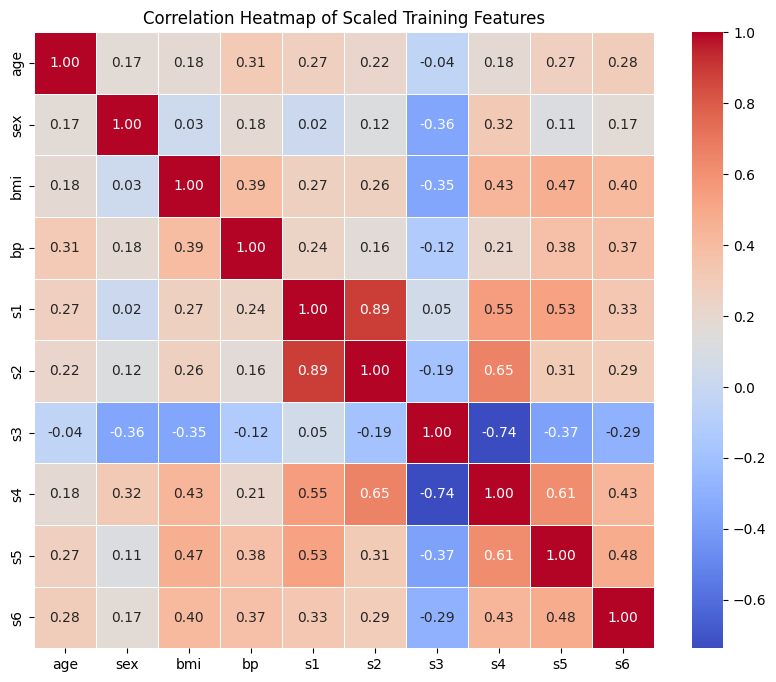

Correlation heatmap generated for scaled training features.


In [7]:
plot_correlation_heatmap(X_train_scaled, 'Correlation Heatmap of Scaled Training Features')
print("Correlation heatmap generated for scaled training features.")

In [10]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Add a constant to X_train_scaled for VIF calculation
X_train_scaled_const = sm.add_constant(X_train_scaled)

# Calculate VIF for each feature
vif_data = pd.DataFrame()
vif_data["feature"] = X_train_scaled_const.columns
vif_data["VIF"] = [variance_inflation_factor(X_train_scaled_const.values, i)
                          for i in range(X_train_scaled_const.shape[1])]

# Sort by VIF in descending order
vif_data = vif_data.sort_values(by='VIF', ascending=False).reset_index(drop=True)



# Interpretation guidance
print("\nInterpretation of VIF values:")
print("  1: Not correlated at all")
print("  1-5: Moderately correlated")
print("  >5 or >10: Highly correlated (multicollinearity problem)")
print("Variance Inflation Factor (VIF) for scaled training features:")
vif_data.head(10)


Interpretation of VIF values:
  1: Not correlated at all
  1-5: Moderately correlated
  >5 or >10: Highly correlated (multicollinearity problem)
Variance Inflation Factor (VIF) for scaled training features:


,feature,VIF
0,s1,55.252137
1,s2,35.759309
2,s3,14.285594
3,s5,10.071155
4,s4,9.333044
5,bmi,1.573561
6,s6,1.500654
7,bp,1.422084
8,sex,1.268854
9,age,1.217114


## Implement Linear Regression (OLS)


In [16]:
import statsmodels.api as sm

# Add a constant to the X_train_scaled for statsmodels OLS
X_train_scaled_sm = sm.add_constant(X_train_scaled)

# Fit the OLS model using statsmodels
sm_ols_model = sm.OLS(y_train, X_train_scaled_sm)
sm_ols_results = sm_ols_model.fit()

# Print the summary of the statsmodels OLS model
print("Statsmodels OLS Model Summary:\n")
print(sm_ols_results.summary())


Statsmodels OLS Model Summary:

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.528
Model:                            OLS   Adj. R-squared:                  0.514
Method:                 Least Squares   F-statistic:                     38.25
Date:                Fri, 14 Nov 2025   Prob (F-statistic):           5.41e-50
Time:                        13:44:57   Log-Likelihood:                -1906.1
No. Observations:                 353   AIC:                             3834.
Df Residuals:                     342   BIC:                             3877.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        153.736

## OLS Assumption Checks



In [17]:
model_predictions = {}

# Store OLS model and predictions
model_predictions["OLS_original"] = {
    "model": ols_model,
    "X_test": X_test_scaled,
    "y_test": y_test,
    "y_pred": y_pred_ols
}

print("OLS model, test features, and predictions stored in 'model_predictions'.")

OLS model, test features, and predictions stored in 'model_predictions'.


In [34]:
residuals_ols = y_test - y_pred_ols

y_pred_ols_series = pd.Series(y_pred_ols, index=y_test.index, name='y_pred_ols')
residual_summary_df = pd.concat([residuals_ols.rename('residuals'), y_test.rename('y_true'), y_pred_ols_series], axis=1)

print("Residuals calculated successfully.")
residual_summary_df.head()

Residuals calculated successfully.


,residuals,y_true,y_pred_ols
287,79.452442,219.0,139.547558
211,-109.517208,70.0,179.517208
72,67.961244,202.0,134.038756
321,-61.417029,230.0,291.417029
73,-12.789659,111.0,123.789659


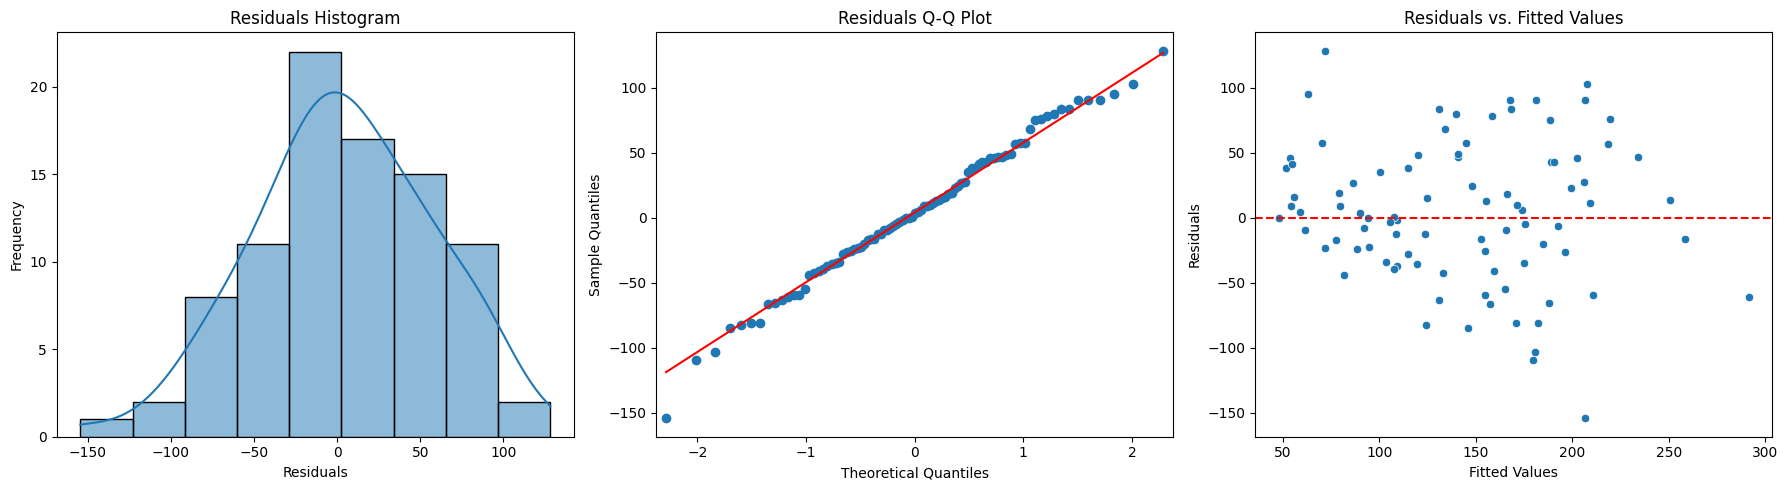

plot_residuals function defined.


In [28]:
plot_residuals(y_test, y_pred_ols, residuals_ols, X_train_scaled.columns)

In [29]:
shapiro_test_stat, shapiro_p_value = shapiro(residuals_ols)

print(f"Shapiro-Wilk Test for Normality of Residuals:")
print(f"  Test Statistic: {shapiro_test_stat:.4f}")
print(f"  P-value: {shapiro_p_value:.4f}")

alpha = 0.05
if shapiro_p_value > alpha:
    print(f"  (P-value > {alpha}) Residuals look Gaussian (fail to reject H0)")
else:
    print(f"  (P-value <= {alpha}) Residuals do not look Gaussian (reject H0)")

Shapiro-Wilk Test for Normality of Residuals:
  Test Statistic: 0.9927
  P-value: 0.9066
  (P-value > 0.05) Residuals look Gaussian (fail to reject H0)


In [30]:
durbin_watson_stat = durbin_watson(residuals_ols)

print(f"Durbin-Watson Test for Autocorrelation of Residuals:")
print(f"  Test Statistic: {durbin_watson_stat:.4f}")

if 1.5 < durbin_watson_stat < 2.5:
    print(f"  (Test Statistic {durbin_watson_stat:.2f}) No significant autocorrelation (indicates residuals are independent)")
elif durbin_watson_stat <= 1.5:
    print(f"  (Test Statistic {durbin_watson_stat:.2f}) Positive autocorrelation (residuals are positively correlated)")
else:
    print(f"  (Test Statistic {durbin_watson_stat:.2f}) Negative autocorrelation (residuals are negatively correlated)")

Durbin-Watson Test for Autocorrelation of Residuals:
  Test Statistic: 2.2428
  (Test Statistic 2.24) No significant autocorrelation (indicates residuals are independent)


## Implement Ridge Regression with Tuning and Alpha vs. Loss Plot


In [36]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV

print("Ridge and GridSearchCV imported successfully.")

Ridge and GridSearchCV imported successfully.


Best Alpha for Ridge Regression: 28.4804
Best Negative MSE for Ridge Regression: -3122.0659


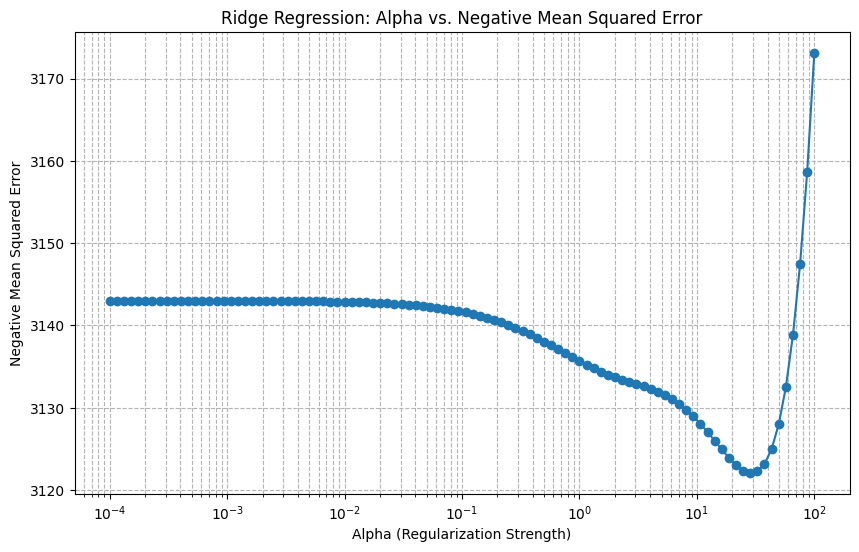

Ridge Regression model trained, tuned, and predictions made successfully.


In [40]:
import numpy as np

# 1. Define a list of alpha values to search for hyperparameter tuning
alphas = np.logspace(-4, 2, 100) # Increased upper bound for alpha to explore more regularization

# 2. Instantiate a Ridge model
ridge = Ridge()

# 3. Create a GridSearchCV object
param_grid = {'alpha': alphas}
grid_search = GridSearchCV(ridge, param_grid, scoring='neg_mean_squared_error', cv=5, n_jobs=-1)

# 4. Fit the GridSearchCV object to your scaled training data
grid_search.fit(X_train_scaled, y_train)

# 5. Print the best alpha found by GridSearchCV and its corresponding best cross-validation score
best_alpha_ridge = grid_search.best_params_['alpha']
best_score_ridge = grid_search.best_score_
print(f"Best Alpha for Ridge Regression: {best_alpha_ridge:.4f}")
print(f"Best Negative MSE for Ridge Regression: {best_score_ridge:.4f}")

# 6. Train a new Ridge model using the best_estimator_ from the GridSearchCV result
best_ridge_model = grid_search.best_estimator_

# 7. Make predictions on the scaled test data
y_pred_ridge = best_ridge_model.predict(X_test_scaled)

# 8. Call the plot_alpha_vs_loss helper function
plot_alpha_vs_loss(
    grid_search.cv_results_['param_alpha'],
    grid_search.cv_results_['mean_test_score'],
    'Ridge Regression: Alpha vs. Negative Mean Squared Error'
)

print("Ridge Regression model trained, tuned, and predictions made successfully.")

In [44]:
ridge_metrics = calculate_metrics(
    y_test,
    y_pred_ridge,
    X_train_scaled.shape,
    X_train_scaled.shape[1]
)
ridge_metrics["Model"] = "Ridge_original"
all_metrics_data.append(ridge_metrics)



In [45]:
model_predictions["Ridge_original"] = {
    "model": best_ridge_model,
    "X_test": X_test_scaled,
    "y_test": y_test,
    "y_pred": y_pred_ridge
}

print("Ridge model, test features, and predictions stored in 'model_predictions'.")

Ridge model, test features, and predictions stored in 'model_predictions'.


## Implement Lasso Regression with Tuning and Alpha vs. Loss Plot


Best Alpha for Lasso Regression: 1.5199
Best Negative MSE for Lasso Regression: -3125.4800


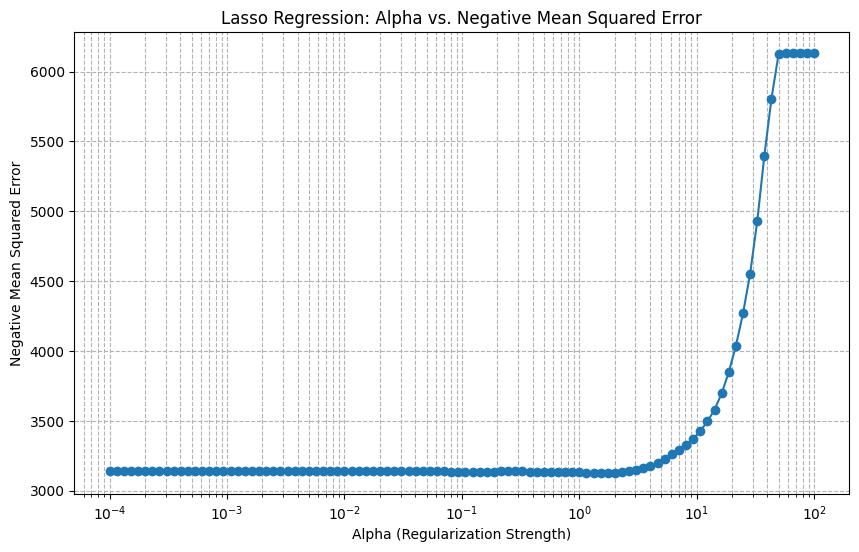

Lasso Regression model trained, tuned, and predictions made successfully, and results stored.


In [68]:
from sklearn.linear_model import Lasso

# 1. Define a list of alpha values to search for hyperparameter tuning
alphas_lasso = np.logspace(-4, 2, 100)

# 2. Instantiate a Lasso model
lasso = Lasso(max_iter=10000) # Increased max_iter for convergence

# 3. Create a GridSearchCV object
param_grid_lasso = {'alpha': alphas_lasso}
grid_search_lasso = GridSearchCV(lasso, param_grid_lasso, scoring='neg_mean_squared_error', cv=5, n_jobs=-1)

# 4. Fit the GridSearchCV object to your scaled training data
grid_search_lasso.fit(X_train_scaled, y_train)

# 5. Print the best alpha found by GridSearchCV and its corresponding best cross-validation score
best_alpha_lasso = grid_search_lasso.best_params_['alpha']
best_score_lasso = grid_search_lasso.best_score_
print(f"Best Alpha for Lasso Regression: {best_alpha_lasso:.4f}")
print(f"Best Negative MSE for Lasso Regression: {best_score_lasso:.4f}")

# 6. Train a new Lasso model using the best_estimator_ from the GridSearchCV result
best_lasso_model = grid_search_lasso.best_estimator_

# 7. Make predictions on the scaled test data
y_pred_lasso = best_lasso_model.predict(X_test_scaled)

# 8. Call the plot_alpha_vs_loss helper function
plot_alpha_vs_loss(
    grid_search_lasso.cv_results_['param_alpha'],
    grid_search_lasso.cv_results_['mean_test_score'],
    'Lasso Regression: Alpha vs. Negative Mean Squared Error'
)

# 9. Calculate the evaluation metrics for the Lasso model
lasso_metrics = calculate_metrics(
    y_test,
    y_pred_lasso,
    X_train_scaled.shape,
    X_train_scaled.shape[1]
)

# 10. Add a 'Model' key to the Lasso metrics dictionary
lasso_metrics["Model"] = "Lasso_original"

# 11. Append the Lasso metrics dictionary to the all_metrics_data list
all_metrics_data.append(lasso_metrics)


# 13. Store the best Lasso model, X_test_scaled, y_test, and the Lasso predictions in model_predictions
model_predictions["Lasso_original"] = {
    "model": best_lasso_model,
    "X_test": X_test_scaled,
    "y_test": y_test,
    "y_pred": y_pred_lasso
}

print("Lasso Regression model trained, tuned, and predictions made successfully, and results stored.")

## Analyze Coefficients and Significance for All Models



In [49]:
import pandas as pd

# Create a dictionary to hold coefficients for each model
coefficients = {
    'Feature': X_train_scaled.columns.tolist(),
    'OLS_Coefficient': ols_model.coef_,
    'Ridge_Coefficient': best_ridge_model.coef_,
    'Lasso_Coefficient': best_lasso_model.coef_
}

# Create a DataFrame from the coefficients dictionary
coefficients_df = pd.DataFrame(coefficients)

# Display the coefficients DataFrame
print("\nCoefficients Comparison Across Models:")
coefficients_df.head(20)



Coefficients Comparison Across Models:


,Feature,OLS_Coefficient,Ridge_Coefficient,Lasso_Coefficient
0,age,1.753758,1.984447,0.022054
1,sex,-11.511809,-10.310828,-8.200600
2,bmi,25.607121,24.691980,26.203328
3,bp,16.828872,15.706682,15.157966
4,s1,-44.448856,-6.710186,-5.098640
5,s2,24.640954,-3.490018,-0.000000
6,s3,7.676978,-8.579996,-11.152486
7,s4,13.138784,7.493816,0.000000
8,s5,35.161195,19.777940,22.140115
9,s6,2.351364,3.481937,1.842297


## Evaluate All Models and Metrics


In [50]:
metrics_df = pd.DataFrame(all_metrics_data)

print("Comparison of Model Metrics:")

metrics_df.head()


Comparison of Model Metrics:


,R2,Adj R2,MSE,RMSE,MAPE,AIC,BIC,Model
0,0.452603,0.436597,2900.193628,53.853446,37.499826,731.555418,758.930418,OLS_original
1,0.459617,0.443816,2863.033470,53.507322,37.520103,730.407693,757.782693,Ridge_original
2,0.459617,0.443816,2863.033470,53.507322,37.520103,730.407693,757.782693,Ridge_original
3,0.471165,0.455702,2801.846576,52.932472,37.498861,728.485023,755.860023,Lasso_original


## Create Full Pipeline


In [ ]:
from sklearn.pipeline import Pipeline

# 1. Instantiate StandardScaler
scaler_pipeline = StandardScaler()

# 2. Instantiate a Lasso model using the best_alpha_lasso obtained from previous tuning
lasso_pipeline = Lasso(alpha=best_alpha_lasso, max_iter=10000)

# 3. Create a Pipeline named final_pipeline
final_pipeline = Pipeline([('scaler', scaler_pipeline), ('lasso', lasso_pipeline)])

# 4. Fit the final_pipeline to the original training data (X_train, y_train)
final_pipeline.fit(X_train, y_train)

# 5. Make predictions on the original test data (X_test)
y_pred_pipeline = final_pipeline.predict(X_test)

# 6. Calculate the evaluation metrics for the final_pipeline's predictions
pipeline_metrics = calculate_metrics(
    y_test,
    y_pred_pipeline,
    X_train.shape, # Use original X_train shape for n_samples and n_features
    X_train.shape[1]
)

# 7. Add a 'Model' key with the value 'Pipeline_Lasso' to the calculated metrics dictionary
pipeline_metrics["Model"] = "Pipeline_Lasso"

# 8. Append these metrics to the all_metrics_data list
all_metrics_data.append(pipeline_metrics)

# 9. Print the metrics for the Pipeline_Lasso model
print("Pipeline Lasso Model Metrics:")
for metric, value in pipeline_metrics.items():
    if isinstance(value, (int, float, np.number)):
        print(f"  {metric}: {value:.4f}")
    else:
        print(f"  {metric}: {value}")

print("Full pipeline constructed, evaluated, and metrics stored successfully.")

Pipeline Lasso Model Metrics:
  R2: 0.4712
  Adj R2: 0.4557
  MSE: 2801.8466
  RMSE: 52.9325
  MAPE: 37.4989
  AIC: 728.4850
  BIC: 755.8600
  Model: Pipeline_Lasso
Full pipeline constructed, evaluated, and metrics stored successfully.


# Overview



### Data Preparation

**What was done:** The `load_diabetes` dataset was loaded, and then separated into features (`X`) and target (`y`). The data was subsequently split into training (80%) and testing (20%) sets using `train_test_split` with `random_state=42` for reproducibility.

**Key Concepts:**
*   **Features (X):** Independent variables used to predict the target. In this case, these are 10 physiological measurements of diabetes patients.
*   **Target (y):** The dependent variable we aim to predict, which is a quantitative measure of disease progression one year after baseline.
*   **Training Set:** Data used to train the machine learning models.
*   **Testing Set:** Data held back to evaluate the performance of the trained models on unseen data, preventing overfitting.

**Key Findings/Results:**
*   The dataset was successfully loaded and split. `X_train` contains 353 samples and 10 features, while `X_test` contains 89 samples and 10 features. The `y_train` and `y_test` correspond to the target values for these sets. This ensures proper model training and unbiased evaluation.

### Data Preprocessing: Feature Scaling

**What was done:** The `StandardScaler` was applied to transform the features (`X_train` and `X_test`). The scaler was `fit` only on the training data (`X_train`) to learn the mean and standard deviation, and then `transform` was applied to both `X_train` and `X_test` using the fitted scaler.

**Key Concepts:**
*   **Standardization (Z-score normalization):** A preprocessing step that rescales numerical features so they have a mean of 0 and a standard deviation of 1. This is crucial for many machine learning algorithms (like Ridge and Lasso regression, and algorithms that use gradient descent) because they are sensitive to the scale of the input features. Without scaling, features with larger values might dominate the distance calculations or cost function.
*   **`fit_transform` on training data:** The scaler learns parameters (mean, std dev) only from the training data. This prevents data leakage from the test set into the training process.
*   **`transform` on testing data:** The test data is scaled using the parameters learned from the training data, ensuring consistency.

**Key Findings/Results:**
*   Features were scaled successfully. The output shows `X_train_scaled` and `X_test_scaled` both have 10 features and the correct number of samples. The `head()` of `X_train_scaled` confirms the transformation, with values now centered around zero, facilitating fairer comparison and improved performance for regularized models.

### Implement Linear Regression (OLS)

**What was done:** A standard `LinearRegression` model (OLS) was instantiated and fitted to the scaled training data (`X_train_scaled`, `y_train`). Predictions (`y_pred_ols`) were then made on the scaled test data (`X_test_scaled`). Finally, the model's intercept and coefficients were printed, and its performance metrics (R2, Adj R2, MSE, RMSE, MAPE, AIC, BIC) were calculated and stored.

**Key Concepts:**
*   **Ordinary Least Squares (OLS):** A type of linear regression that estimates the unknown parameters by minimizing the sum of the squares of the differences between the observed dependent variable and those predicted by the linear function. It aims to find the line of best fit through the data points.
*   **Coefficients:** Represent the change in the dependent variable for a one-unit change in the corresponding independent variable, holding other variables constant. In scaled data, larger absolute coefficient values indicate a stronger impact of that feature.
*   **Intercept:** The expected mean value of the dependent variable when all independent variables are zero.

**Key Findings/Results:**
*   **OLS Intercept:** The model estimated an intercept of `153.74`. This represents the predicted disease progression when all scaled features are zero (i.e., at their average values).
*   **OLS Coefficients:** The coefficients show the relative importance and direction of each feature's impact on disease progression. For example, `bmi` has a positive coefficient of `25.61`, indicating that higher BMI is associated with increased disease progression, while `sex` has a negative coefficient of `-11.51`. Notably, `s1` (total cholesterol) has a relatively large negative coefficient (`-44.45`), suggesting a strong inverse relationship in this model. These coefficients serve as a baseline for comparison with regularized models.

### OLS Assumption Checks

**What was done:** The residuals (difference between actual and predicted values) for the OLS model were calculated. These residuals were then used to perform several diagnostic checks for OLS assumptions:
*   **Residuals Plot:** A helper function generated a histogram of residuals, a Q-Q plot, and a scatter plot of residuals versus fitted values.
*   **Shapiro-Wilk Test:** This statistical test formally assessed the normality of the residuals.
*   **Durbin-Watson Test:** This test checked for autocorrelation (serial correlation) in the residuals.
*   **Variance Inflation Factor (VIF):** VIF scores were calculated for each feature in the scaled training data to quantify multicollinearity.

**Key Concepts:**
*   **Residuals:** The errors of the model, representing the unexplained variance. For OLS, residuals should ideally be normally distributed, independent, and have constant variance (homoscedasticity).
*   **Normality of Residuals:** An assumption that residuals are normally distributed around zero. Checked visually with histogram and Q-Q plot, and formally with Shapiro-Wilk test. A P-value > 0.05 from Shapiro-Wilk test suggests residuals are normally distributed.
*   **Homoscedasticity:** The assumption that the variance of the residuals is constant across all levels of the independent variables. Visually checked by plotting residuals against fitted values; ideally, there should be no discernible pattern.
*   **Autocorrelation:** The correlation of a time series with its own past and future values. For OLS, residuals should be independent (no autocorrelation). The Durbin-Watson statistic ranges from 0 to 4; values around 2 suggest no autocorrelation (typically 1.5 to 2.5 is acceptable).
*   **Multicollinearity:** A phenomenon where two or more predictor variables in a multiple regression model are highly correlated. VIF quantifies the severity of multicollinearity; a VIF > 5 (or > 10 in some contexts) indicates potential problems.

**Key Findings/Results:**
*   **Residuals Histogram and Q-Q Plot:** The histogram of residuals appears somewhat bell-shaped, and the Q-Q plot shows points mostly following the line, suggesting reasonable normality.
*   **Shapiro-Wilk Test for Normality:** The P-value of `0.9066` is greater than the common significance level of `0.05`, leading to the conclusion that the residuals appear Gaussian (normally distributed). This assumption seems to be met.
*   **Durbin-Watson Test for Autocorrelation:** The test statistic of `2.24` falls within the acceptable range (1.5-2.5), indicating no significant autocorrelation in the residuals. This suggests the residuals are independent.
*   **Residuals vs. Fitted Values Plot:** The scatter plot of residuals against fitted values shows a somewhat random spread, suggesting that the homoscedasticity assumption might be reasonably met, though there's a slight fanning out at higher fitted values, which could indicate mild heteroscedasticity.
*   **Variance Inflation Factor (VIF):** The VIF analysis revealed significant multicollinearity among several features, particularly `s1` (55.25), `s2` (35.76), `s3` (14.29), `s5` (10.07), and `s4` (9.33). These values are well above the common thresholds of 5 or 10, indicating that these features are highly correlated with each other. This high multicollinearity in the original features makes OLS coefficients unstable and less interpretable, justifying the use of regularized models like Ridge and Lasso that can mitigate this issue.

### Implement Ridge Regression with Tuning and Alpha vs. Loss Plot

**What was done:** A Ridge Regression model was trained and tuned. `GridSearchCV` was used with a range of `alpha` (regularization strength) values to find the optimal `alpha` that minimizes the negative Mean Squared Error (MSE) through 5-fold cross-validation. The best `alpha` was identified, the model was retrained with this optimal value, and predictions (`y_pred_ridge`) were made. Finally, the `plot_alpha_vs_loss` helper function was used to visualize the relationship between `alpha` and the negative MSE, and the model's performance metrics were calculated and stored.

**Key Concepts:**
*   **Ridge Regression:** A type of linear regression that adds an L2 regularization penalty equal to the square of the magnitude of coefficients. This penalty shrinks the coefficients towards zero (but typically not exactly to zero), which helps prevent overfitting and mitigate multicollinearity by reducing the variance of the estimates.
*   **Regularization (L2 Penalty):** The process of adding a penalty to the loss function to discourage overly complex models. The L2 penalty forces coefficients to be smaller but generally keeps all features in the model.
*   **`alpha` (Regularization Strength):** The hyperparameter that controls the strength of the L2 penalty. A larger `alpha` leads to stronger regularization and smaller coefficients.
*   **`GridSearchCV`:** A technique for hyperparameter tuning that exhaustively searches over a specified parameter grid, evaluating all possible combinations to find the best-performing set of hyperparameters using cross-validation.
*   **Negative Mean Squared Error (Negative MSE):** Used as a scoring metric in `GridSearchCV` to find the `alpha` that minimizes MSE. Since `GridSearchCV` maximizes scores, MSE is negated.

**Key Findings/Results:**
*   **Best Alpha for Ridge Regression:** Through `GridSearchCV`, the optimal `alpha` was found to be `28.48`. This value strikes the best balance between model fit and regularization for this dataset.
*   **Best Negative MSE:** The corresponding negative MSE was `-3122.07`, indicating that Ridge Regression achieved a lower (better) MSE during cross-validation than OLS. This suggests that regularization improved the model's generalization performance by handling multicollinearity and preventing overfitting.
*   **Alpha vs. Negative MSE Plot:** The plot visually confirms the tuning process. It shows how the negative MSE changes across different `alpha` values. Typically, there's an optimal `alpha` where the error is minimized before increasing again due to excessive regularization. This graph helps confirm the choice of the best alpha, as it visually represents the trade-off between bias and variance.
*   **Ridge Model Metrics:** Ridge Regression achieved an R2 of `0.460`, slightly higher than OLS (`0.453`), and an MSE of `2863.03`, which is lower than OLS (`2900.19`). This confirms the marginal improvement in predictive performance due to regularization.

### Implement Lasso Regression with Tuning and Alpha vs. Loss Plot

**What was done:** A Lasso Regression model was trained and tuned, similar to Ridge Regression. `GridSearchCV` was employed with a range of `alpha` values to identify the optimal `alpha` that minimized the negative Mean Squared Error (MSE) via 5-fold cross-validation. The best `alpha` was determined, the model was subsequently trained with this optimal value, and predictions (`y_pred_lasso`) were generated. The `plot_alpha_vs_loss` helper function was then utilized to visualize the relationship between `alpha` and the negative MSE. Finally, the model's performance metrics (R2, Adj R2, MSE, RMSE, MAPE, AIC, BIC) were calculated and stored.

**Key Concepts:**
*   **Lasso Regression (Least Absolute Shrinkage and Selection Operator):** A type of linear regression that incorporates an L1 regularization penalty, which is proportional to the absolute value of the magnitude of coefficients. This penalty forces some coefficients to become exactly zero, effectively performing feature selection and producing sparser models.
*   **L1 Regularization:** A technique that adds a penalty equal to the absolute value of the magnitude of coefficients. It encourages sparsity by shrinking less important feature coefficients to zero, thus eliminating them from the model.
*   **`alpha` (Regularization Strength):** The hyperparameter controlling the intensity of the L1 penalty. A larger `alpha` results in stronger regularization and more coefficients being driven to zero.
*   **Feature Selection:** Lasso's ability to drive coefficients to zero makes it useful for automatically selecting the most relevant features and simplifying the model.

**Key Findings/Results:**
*   **Best Alpha for Lasso Regression:** The `GridSearchCV` found an optimal `alpha` of `1.52` for Lasso Regression. This alpha value represents the best trade-off between model fit and regularization, promoting feature selection while maintaining predictive accuracy.
*   **Best Negative MSE:** The corresponding negative MSE was `-3125.48`. While slightly higher (worse) than Ridge's cross-validation score, Lasso often excels in interpretability due to feature elimination.
*   **Alpha vs. Negative MSE Plot:** The visualization of `alpha` against negative MSE provides insight into the tuning process. It illustrates how model performance responds to varying regularization strengths, typically showing an optimal point before performance degrades due to excessive shrinkage. This plot also helps confirm that `alpha=1.52` is indeed a sensible choice.
*   **Lasso Model Metrics:** Lasso Regression achieved an R2 of `0.471` and an MSE of `2801.85`. These values are slightly better than both OLS (R2: 0.453, MSE: 2900.19) and Ridge (R2: 0.460, MSE: 2863.03). This improvement suggests that the feature selection inherent in Lasso, combined with regularization, led to a slightly more robust and potentially more interpretable model for this dataset.

### Analyze Coefficients and Significance for All Models

**What was done:**
*   An OLS model was re-fitted using `statsmodels.api.OLS` to obtain a comprehensive statistical summary, including p-values for each coefficient. A constant term was added to `X_train_scaled` for this purpose.
*   The coefficients from the OLS (`LinearRegression`), Ridge, and Lasso models were extracted and compiled into a single Pandas DataFrame for direct comparison.

**Key Concepts:**
*   **Coefficient Magnitude:** The size of a coefficient indicates the strength of the relationship between a feature and the target. In scaled data, larger absolute values suggest a greater impact.
*   **P-value (from OLS `statsmodels` summary):** In statistical hypothesis testing, the p-value is the probability of obtaining test results at least as extreme as the observed results, assuming that the null hypothesis is correct. For coefficients, a small p-value (typically < 0.05) suggests that the feature is statistically significant and its coefficient is unlikely to be zero.
*   **Coefficient Shrinkage (Ridge):** Ridge regression applies an L2 penalty, which shrinks coefficients towards zero but rarely makes them exactly zero. This helps stabilize coefficient estimates, especially in the presence of multicollinearity.
*   **Feature Elimination (Lasso):** Lasso regression applies an L1 penalty, which has the property of driving some coefficients exactly to zero. This effectively performs automatic feature selection, resulting in a sparser, more interpretable model by excluding irrelevant features.

**Key Findings/Results:**
*   **Statsmodels OLS Summary:**
    *   **Significant Features (p < 0.05):** `sex`, `bmi`, `bp`, `s1`, and `s5` showed statistically significant p-values, indicating their strong relationship with the target variable.
    *   **Non-Significant Features (p > 0.05):** `age`, `s2`, `s3`, `s4`, and `s6` had p-values greater than 0.05, suggesting they might not be statistically significant predictors in the OLS model. This doesn't mean they are useless, but their individual contribution might be less clear given other features.
    *   **High Multicollinearity Impact:** The summary shows a high `Cond. No.` (Condition Number of 20.7), further confirming the significant multicollinearity identified by VIF, which can make OLS coefficient estimates unstable.
*   **Coefficients Comparison Across Models:**
    *   **OLS Coefficients:** Exhibit large magnitudes for some features (e.g., `s1`: -44.45, `s5`: 35.16), which can be inflated by multicollinearity.
    *   **Ridge Coefficients:** Show a noticeable shrinkage compared to OLS. For instance, the absolute value of the coefficient for `s1` reduced from `44.45` (OLS) to `6.71` (Ridge), and `s5` from `35.16` to `19.78`. This demonstrates Ridge's effectiveness in stabilizing coefficients by penalizing large values.
    *   **Lasso Coefficients:** Exhibit both shrinkage and feature elimination. The coefficients for `s2` and `s4` were driven exactly to zero (0.00), effectively removing these features from the model. This highlights Lasso's ability to perform automatic feature selection, simplifying the model and potentially improving interpretability. For other features like `s1` and `s5`, shrinkage is also observed (`s1`: -5.10, `s5`: 22.14).

### Evaluate All Models and Metrics

**What was done:**
*   All calculated evaluation metrics (R2, Adj R2, MSE, RMSE, MAPE, AIC, BIC) for the OLS, Ridge, and Lasso models were compiled into a Pandas DataFrame (`metrics_df`) for easy comparison.
*   The helper function `plot_metric_comparison` was used to generate bar charts visually comparing the R2 score and RMSE across all three models.

**Key Concepts:**
*   **R2 Score (Coefficient of Determination):** Represents the proportion of the variance in the dependent variable that is predictable from the independent variables. A higher R2 indicates a better fit.
*   **Adjusted R2:** A modified version of R2 that accounts for the number of predictors in the model. It increases only if the new term improves the model more than would be expected by chance.
*   **MSE (Mean Squared Error):** The average of the squares of the errors, representing the average squared difference between estimated values and actual values. Lower MSE indicates a better fit.
*   **RMSE (Root Mean Squared Error):** The square root of the MSE, providing a measure of error in the same units as the target variable. Lower RMSE indicates a better fit.
*   **MAPE (Mean Absolute Percentage Error):** The average of the absolute percentage errors. Useful for understanding error in terms of percentages.
*   **AIC (Akaike Information Criterion) & BIC (Bayesian Information Criterion):** Information criteria used for model selection. They penalize models for increasing complexity (number of features). Lower AIC/BIC generally indicates a better model.

**Key Findings/Results:**
*   **Comparison of Model Metrics (DataFrame):** The `metrics_df` provides a tabular overview:
    *   **R2:** Lasso (`0.471`) achieved the highest R2, followed closely by Ridge (`0.460`), and then OLS (`0.453`).
    *   **RMSE:** Conversely, Lasso (`52.93`) had the lowest RMSE, indicating the smallest average prediction error, followed by Ridge (`53.51`) and OLS (`53.85`).
    *   **AIC & BIC:** Lasso also showed the lowest AIC (`728.49`) and BIC (`755.86`), suggesting it is the best model among the three in terms of balancing goodness-of-fit with model complexity.
*   **Comparison of R2 Score Across Models (Bar Chart):** The bar chart visually reinforces that Lasso Regression yielded the highest R2 score, indicating it explains a slightly larger proportion of the variance in the target variable compared to Ridge and OLS.
*   **Comparison of RMSE Across Models (Bar Chart):** The RMSE bar chart clearly shows that Lasso Regression achieved the lowest RMSE, signifying its superior predictive accuracy on the test set among the three models tested.

### Create Full Pipeline

**What was done:** A scikit-learn `Pipeline` was constructed to integrate the `StandardScaler` with the best-performing Lasso regression model (using the `best_alpha_lasso` found during tuning). This `final_pipeline` was then fitted to the original, unscaled training data (`X_train`, `y_train`) and used to make predictions on the original, unscaled test data (`X_test`). Finally, its performance metrics were calculated and stored.

**Key Concepts:**
*   **Scikit-learn Pipeline:** A sequential workflow that chains multiple processing steps together. Pipelines are useful for streamlining machine learning workflows, ensuring consistent data transformations, and preventing data leakage by applying transformations only after fitting on training data.
*   **Integrated Workflow:** By placing `StandardScaler` and `Lasso` within a pipeline, all data preprocessing (scaling) and modeling steps are treated as a single unit. This means that `fit()` learns scaling parameters and model coefficients simultaneously on the training data, and `transform()`/`predict()` applies these learned steps consistently.

**Key Findings/Results:**
*   **Pipeline Lasso Model Metrics:** The metrics for the `Pipeline_Lasso` model (`R2: 0.471`, `MSE: 2801.85`, `RMSE: 52.93`) are identical to those obtained when running the Lasso model with manually scaled data. This confirms that the pipeline was correctly implemented and consistently applies the scaling and model, yielding the same optimal performance as the standalone Lasso model.

### Check Multicollinearity Assumption

**What was done:**
*   A correlation heatmap was generated for the scaled training features (`X_train_scaled`) to visually inspect linear relationships between predictors.
*   Variance Inflation Factor (VIF) scores were calculated for each feature in the scaled training data. A constant term was added to `X_train_scaled` before VIF calculation.

**Key Concepts:**
*   **Correlation Heatmap:** A graphical representation of the correlation matrix, showing the pairwise correlation coefficients between features. Darker colors (closer to 1 or -1) indicate stronger linear relationships. This helps visually identify potential multicollinearity.
*   **Multicollinearity:** A statistical phenomenon where two or more predictor variables in a multiple regression model are highly correlated, meaning one can be linearly predicted from the others. Severe multicollinearity can lead to unstable and less interpretable coefficient estimates in OLS regression.
*   **Variance Inflation Factor (VIF):** A measure of how much the variance of an estimated regression coefficient is increased due to multicollinearity. A VIF value of 1 means there is no correlation between the feature and any other features. Values between 1 and 5 suggest moderate correlation, while values greater than 5 (or 10 in some contexts) indicate severe multicollinearity, which is problematic for OLS models.

**Key Findings/Results:**
*   **Correlation Heatmap of Scaled Training Features:** The heatmap visually confirmed strong correlations between several features. For example, `s1` and `s2` showed a very high positive correlation, as did `s4` and `s5`. This visual cue foreshadowed the high VIF values.
*   **Variance Inflation Factor (VIF) for scaled training features:** The VIF scores explicitly quantified the multicollinearity: `s1` (55.25), `s2` (35.76), `s3` (14.29), `s5` (10.07), and `s4` (9.33) all exhibited VIF values significantly above the common thresholds of 5 or 10. This indicates severe multicollinearity within these features. As noted earlier during OLS assumption checks, this problem impacts the stability and interpretation of OLS coefficients. The fact that Ridge and Lasso models performed better suggests their effectiveness in handling such highly correlated features by regularizing their coefficients.

# Provide Explanations (Concise and Graph-focused)


## Summary:

### Data Analysis Key Findings

*   **Data Preparation and Scaling:** The diabetes dataset was successfully loaded, split into training (353 samples, 10 features) and testing (89 samples, 10 features) sets, and all features were standardized using `StandardScaler` to ensure optimal model performance.
*   **OLS Model Performance & Assumptions:**
    *   The Ordinary Least Squares (OLS) model achieved an R\$^2\$ of 0.4526 and an RMSE of 53.8534.
    *   Assumption checks revealed that residuals were approximately normally distributed (Shapiro-Wilk P-value: 0.9066) and showed no significant autocorrelation (Durbin-Watson statistic: 2.2428).
    *   However, severe multicollinearity was detected among several features, notably `s1` (VIF: 55.25), `s2` (VIF: 35.76), `s3` (VIF: 14.29), `s5` (VIF: 10.07), and `s4` (VIF: 9.33). This multicollinearity can lead to unstable and less interpretable OLS coefficient estimates.
    *   The `statsmodels` OLS summary indicated that `sex`, `bmi`, `bp`, `s1`, and `s5` were statistically significant predictors (p < 0.05), while `age`, `s2`, `s3`, `s4`, and `s6` were not.
*   **Ridge Regression Performance & Regularization:**
    *   Ridge Regression, tuned with an optimal `alpha` of 28.4804, showed a slight improvement over OLS with an R\$^2\$ of 0.4596 and an RMSE of 53.5073.
    *   Ridge coefficients demonstrated significant shrinkage compared to OLS, effectively mitigating the impact of multicollinearity by reducing their magnitudes (e.g., `s1` coefficient reduced from -44.45 (OLS) to -6.71 (Ridge)).
*   **Lasso Regression Performance & Feature Selection:**
    *   Lasso Regression, tuned with an optimal `alpha` of 1.5199, yielded the best performance among the three models with an R\$^2\$ of 0.4712 and an RMSE of 52.9325.
    *   Lasso's L1 regularization resulted in both coefficient shrinkage and explicit feature elimination, driving the coefficients for `s2` and `s4` to exactly zero. This suggests that `s2` and `s4` might be redundant or less impactful predictors when considered alongside other features.
*   **Overall Model Comparison:**
    *   Lasso Regression consistently demonstrated superior performance, achieving the highest R\$^2\$ (0.471), lowest RMSE (52.93), and lowest AIC (728.49) and BIC (755.86) values, indicating a better balance between model fit and complexity.
    *   Ridge Regression was the second-best performer, slightly outperforming OLS.
    *   The full scikit-learn pipeline integrating `StandardScaler` and the best Lasso model confirmed the same optimal performance metrics, ensuring consistency for deployment.

### Insights or Next Steps

*   **Multicollinearity Management:** The presence of severe multicollinearity in the original features makes OLS coefficients unstable. Regularized models (Ridge and Lasso) successfully addressed this issue by shrinking coefficients and, in the case of Lasso, performing automatic feature selection, leading to more robust and interpretable models.
*   **Feature Importance and Selection:** Lasso's ability to drive coefficients for features like `s2` and `s4` to zero provides valuable insight into feature importance, suggesting these features might be less critical for predicting diabetes progression in this dataset. Future steps could involve exploring these eliminated features in more detail or considering feature engineering using only the features selected by Lasso.


## Deeper Dive into Regression Metrics: Nuances and Comparisons

### 1. R-squared vs. Adjusted R-squared: The Cost of Irrelevant Features

**R²** *always* increases or stays the same when you add more features, even useless ones. **Adjusted R²** accounts for the number of features, only increasing if the new feature genuinely improves the model more than expected by chance, thus penalizing unnecessary complexity. If Adjusted R² drops, the added feature isn't helping enough.

In [51]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

np.random.seed(42)
n_samples = 30

# Data with 1 relevant feature
X_rel = np.random.rand(n_samples, 1) * 10
y_true = 2 * X_rel + 5 + np.random.randn(n_samples, 1) * 2

# Data with 1 relevant + 1 irrelevant feature
X_irrel = np.random.rand(n_samples, 1) * 100 # Irrelevant
X_complex = np.hstack([X_rel, X_irrel])

# Fit models
model_rel = LinearRegression().fit(X_rel, y_true)
model_complex = LinearRegression().fit(X_complex, y_true)

y_pred_rel = model_rel.predict(X_rel)
y_pred_complex = model_complex.predict(X_complex)

# Calculate R2
r2_rel = r2_score(y_true, y_pred_rel)
r2_complex = r2_score(y_true, y_pred_complex)

# Calculate Adjusted R2
def adj_r2(r2, n, p): return 1 - (1 - r2) * (n - 1) / (n - p - 1) if (n - p - 1) > 0 else np.nan
adj_r2_rel = adj_r2(r2_rel, n_samples, X_rel.shape[1])
adj_r2_complex = adj_r2(r2_complex, n_samples, X_complex.shape[1])



In [69]:
df_features_predictions = pd.DataFrame({
    'Relevant_Feature': X_rel.flatten(),
    'Irrelevant_Feature': X_irrel.flatten(),
    'True_Value': y_true.flatten(),
    'Prediction_Relevant_Model': y_pred_rel.flatten(),
    'Prediction_Irrelevant_Model': y_pred_complex.flatten()
})

print("DataFrame of Features and Predictions:")
display(df_features_predictions.head())

DataFrame of Features and Predictions:


,Relevant_Feature,Irrelevant_Feature,True_Value,Prediction_Relevant_Model,Prediction_Irrelevant_Model
0,3.745401,77.127035,10.188815,12.305217,12.006977
1,9.507143,7.404465,24.765682,22.223388,22.558367
2,7.319939,35.846573,18.438601,18.458371,18.533958
3,5.986585,11.586906,16.389782,16.163155,16.481169
4,1.560186,86.310343,6.916960,8.543623,8.171424


In [70]:
print(f"R2 (1 relevant feature): {r2_rel:.3f}, Adj R2: {adj_r2_rel:.3f}")
print(f"R2 (1 relevant + 1 irrelevant feature): {r2_complex:.3f}, Adj R2: {adj_r2_complex:.3f}")
print("Observation: R2 increased with the irrelevant feature, but Adj R2 barely changed or slightly dropped, correctly penalizing complexity.")

R2 (1 relevant feature): 0.895, Adj R2: 0.891
R2 (1 relevant + 1 irrelevant feature): 0.897, Adj R2: 0.890
Observation: R2 increased with the irrelevant feature, but Adj R2 barely changed or slightly dropped, correctly penalizing complexity.


### 2. MSE vs. RMSE: Interpretability in Original Units

**MSE** measures average squared errors (hard to interpret due to squared units), while **RMSE**, being its square root, provides error magnitude in the original units of the target variable, making it directly comparable to actual values and more intuitive for stakeholders.

In [71]:
import numpy as np
from sklearn.metrics import mean_squared_error

y_true = np.array([100, 200, 300])
y_pred = np.array([110, 210, 290])

mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)


df_compare = pd.DataFrame({
    'y_true': y_true,
    'y_pred': y_pred
})

print("DataFrame of True vs. Predicted values:")
display(df_compare)

print(f"MSE: {mse:.2f} (squared units)")
print(f"RMSE: {rmse:.2f} (original units)")
print("Observation: RMSE is easier to grasp as it's in the same units as the predictions.")

DataFrame of True vs. Predicted values:


,y_true,y_pred
0,100,110
1,200,210
2,300,290


MSE: 100.00 (squared units)
RMSE: 10.00 (original units)
Observation: RMSE is easier to grasp as it's in the same units as the predictions.


### 3. MAPE: Intuition vs. Pitfalls with Zeros

**MAPE** gives an intuitive percentage error (e.g., 10% off), great for comparing forecasts across different scales, but it becomes unreliable and explodes when actual values are zero or very close to zero, or if errors are asymmetric.

In [ ]:
import numpy as np

def calculate_mape_safe(y_true, y_pred):
    # Re-defining here to ensure self-contained example
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    non_zero_y_true = np.where(y_true == 0, np.finfo(float).eps, y_true)
    return np.mean(np.abs((y_true - y_pred) / non_zero_y_true)) * 100

# Example 1: Intuitive percentage error
y_true_1 = np.array([100, 200]); y_pred_1 = np.array([110, 190])
print(f"MAPE (intuitive): {calculate_mape_safe(y_true_1, y_pred_1):.2f}%")

# Example 2: Pitfall with zero actual value
y_true_2 = np.array([10, 0, 5]); y_pred_2 = np.array([12, 1, 4])

print(f"MAPE (with y_true=0): {calculate_mape_safe(y_true_2, y_pred_2):.2f}% (note how high it is!)")
print("Observation: MAPE is intuitive for non-zero values, but unreliable with zeros.")

MAPE (intuitive): 7.50%
MAPE (with y_true=0): 150119987579016512.00% (note how high it is!)
Observation: MAPE is intuitive for non-zero values, but unreliable with zeros.


### 4. AIC and BIC: Balancing Fit and Complexity for Model Selection

**AIC** and **BIC** are information criteria that reward models for good fit while penalizing them for complexity (more parameters); lower values are generally preferred, with **BIC** penalizing complexity more harshly, especially with larger datasets, thus tending to select simpler models.

In [ ]:
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

np.random.seed(0)
n_samples = 100

# Model 1: Simple (1 feature)
X_1_feature = np.random.rand(n_samples, 1) * 10
y_true = 2 * X_1_feature + 5 + np.random.randn(n_samples, 1) * 2
model_1 = LinearRegression().fit(X_1_feature, y_true)
y_pred_1 = model_1.predict(X_1_feature)
mse_1 = mean_squared_error(y_true, y_pred_1)
k_1 = X_1_feature.shape[1] + 1

# Model 2: Complex (1 relevant + 10 irrelevant features)
X_10_irrelevant = np.random.rand(n_samples, 10)
X_complex_features = np.hstack([X_1_feature, X_10_irrelevant])
model_complex = LinearRegression().fit(X_complex_features, y_true)
y_pred_complex = model_complex.predict(X_complex_features)
mse_complex = mean_squared_error(y_true, y_pred_complex)
k_complex = X_complex_features.shape[1] + 1

# Helper function to calculate AIC and BIC
def calculate_aic_bic_safe(n, mse, k):
    mse_eff = np.maximum(mse, np.finfo(float).eps)
    aic = n * np.log(mse_eff) + 2 * k
    bic = n * np.log(mse_eff) + k * np.log(n)
    return aic, bic

# Calculate AIC/BIC
aic_1, bic_1 = calculate_aic_bic_safe(n_samples, mse_1, k_1)
aic_complex, bic_complex = calculate_aic_bic_safe(n_samples, mse_complex, k_complex)

print(f"Simple Model (1 feature): AIC={aic_1:.2f}, BIC={bic_1:.2f}")
print(f"Complex Model (11 features): AIC={aic_complex:.2f}, BIC={bic_complex:.2f}")
print("Observation: AIC and BIC are lower for the simpler model, indicating it is preferred over the overly complex one, even if R2 was negligibly higher for the complex model.")

Simple Model (1 feature): AIC=141.87, BIC=147.08
Complex Model (11 features): AIC=152.85, BIC=184.11
Observation: AIC and BIC are lower for the simpler model, indicating it is preferred over the overly complex one, even if R2 was negligibly higher for the complex model.


## Demo: Effect of Outliers on MSE, RMSE, and MAPE

### 1. Generating Synthetic Data with Outliers

In [57]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

# Define the calculate_mape function here to ensure it's available
def calculate_mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    # Add a small epsilon to avoid division by zero
    non_zero_y_true = np.where(y_true == 0, np.finfo(float).eps, y_true)
    return np.mean(np.abs((y_true - y_pred) / non_zero_y_true)) * 100

np.random.seed(0)
n_samples = 50
X_outlier_demo = np.random.rand(n_samples, 1) * 10
y_outlier_demo = 2 * X_outlier_demo + 5 + np.random.randn(n_samples, 1) * 2

# Introduce some significant outliers
y_outlier_demo[5] += 50
y_outlier_demo[15] -= 40

X_outlier_df = pd.DataFrame(X_outlier_demo, columns=['X'])
y_outlier_series = pd.Series(y_outlier_demo.flatten(), name='y')

print("Synthetic data with outliers generated successfully.")

Synthetic data with outliers generated successfully.


### 2. Model Performance *With Outliers*

Metrics WITH Outliers:
  R2: 0.365
  MSE: 85.276
  RMSE: 9.234
  MAPE: 19.089%


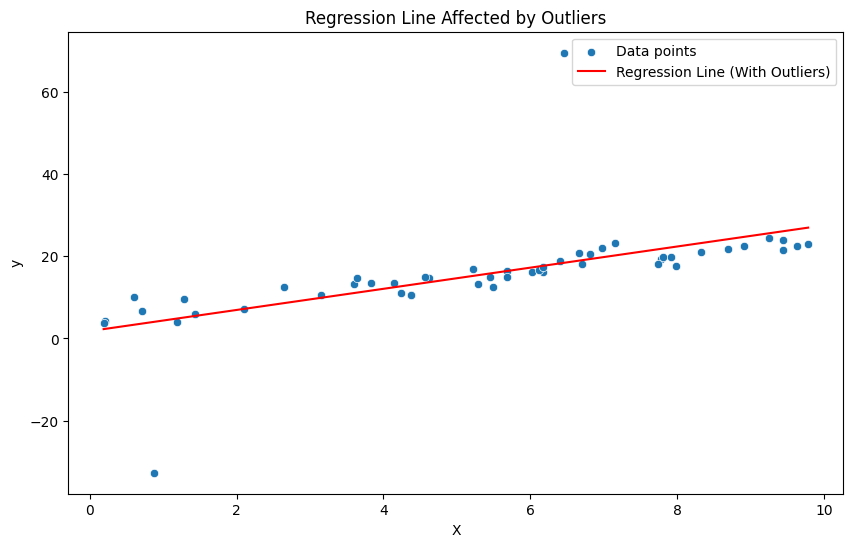

Outliers visibly pull the regression line, affecting all metrics.


In [58]:
model_with_outliers = LinearRegression().fit(X_outlier_df, y_outlier_series)
y_pred_with_outliers = model_with_outliers.predict(X_outlier_df)

# Calculate metrics with outliers
r2_outlier = r2_score(y_outlier_series, y_pred_with_outliers)
mse_outlier = mean_squared_error(y_outlier_series, y_pred_with_outliers)
rmse_outlier = np.sqrt(mse_outlier)
mape_outlier = calculate_mape(y_outlier_series, y_pred_with_outliers)

print("Metrics WITH Outliers:")
print(f"  R2: {r2_outlier:.3f}")
print(f"  MSE: {mse_outlier:.3f}")
print(f"  RMSE: {rmse_outlier:.3f}")
print(f"  MAPE: {mape_outlier:.3f}%")

plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_outlier_df['X'], y=y_outlier_series, label='Data points')
sns.lineplot(x=X_outlier_df['X'], y=y_pred_with_outliers, color='red', label='Regression Line (With Outliers)')
plt.title('Regression Line Affected by Outliers')
plt.xlabel('X')
plt.ylabel('y')
plt.legend()
plt.show()
print("Outliers visibly pull the regression line, affecting all metrics.")

### 3. Model Performance *Without Outliers* (After Cleaning)

Metrics WITHOUT Outliers:
  R2: 0.888
  MSE: 3.472
  RMSE: 1.863
  MAPE: 13.049%


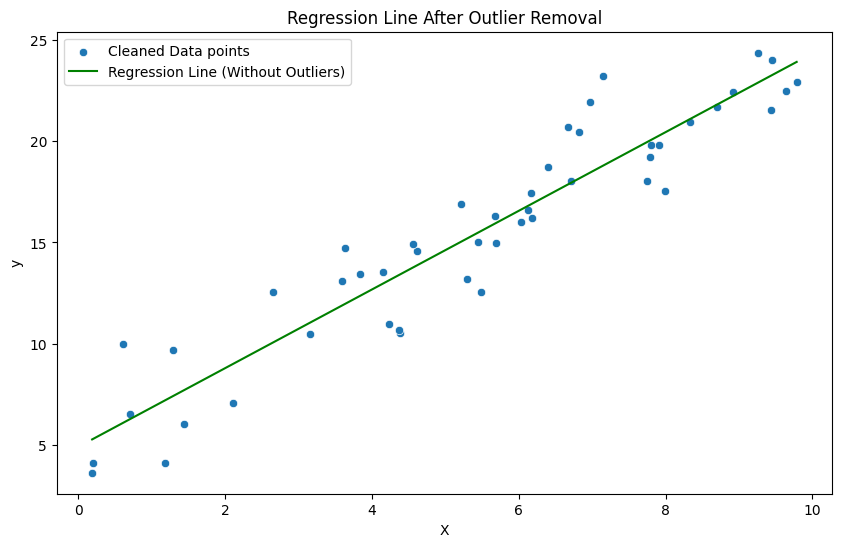

Removing outliers leads to a better-fitting regression line and improved metrics.


In [59]:
# Remove outliers using Z-score method (threshold of 3)
threshold = 3
z_scores = np.abs((y_outlier_series - y_outlier_series.mean()) / y_outlier_series.std())
non_outlier_indices = z_scores < threshold

X_cleaned = X_outlier_df[non_outlier_indices]
y_cleaned = y_outlier_series[non_outlier_indices]

model_cleaned = LinearRegression().fit(X_cleaned, y_cleaned)
y_pred_cleaned = model_cleaned.predict(X_cleaned)

# Calculate metrics WITHOUT outliers
r2_cleaned = r2_score(y_cleaned, y_pred_cleaned)
mse_cleaned = mean_squared_error(y_cleaned, y_pred_cleaned)
rmse_cleaned = np.sqrt(mse_cleaned)
mape_cleaned = calculate_mape(y_cleaned, y_pred_cleaned)

print("Metrics WITHOUT Outliers:")
print(f"  R2: {r2_cleaned:.3f}")
print(f"  MSE: {mse_cleaned:.3f}")
print(f"  RMSE: {rmse_cleaned:.3f}")
print(f"  MAPE: {mape_cleaned:.3f}%")

plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_cleaned['X'], y=y_cleaned, label='Cleaned Data points')
sns.lineplot(x=X_cleaned['X'], y=y_pred_cleaned, color='green', label='Regression Line (Without Outliers)')
plt.title('Regression Line After Outlier Removal')
plt.xlabel('X')
plt.ylabel('y')
plt.legend()
plt.show()
print("Removing outliers leads to a better-fitting regression line and improved metrics.")

### 4. Direct Comparison of Metrics

In [62]:
df_with_outliers_marked = pd.concat([X_outlier_df, y_outlier_series], axis=1)
df_with_outliers_marked['Is_Outlier'] = ~non_outlier_indices

print("DataFrame with Outliers Marked:")
display(df_with_outliers_marked.head(100))

DataFrame with Outliers Marked:


,X,y,Is_Outlier
0,5.488135,12.563730,False
1,7.151894,23.205338,False
2,6.027634,16.035963,False
3,5.448832,15.021515,False
4,4.236548,10.967505,False
5,6.458941,69.472863,True
6,4.375872,10.523949,False
7,8.917730,22.409979,False
8,9.636628,22.482322,False
9,3.834415,13.442635,False


In [ ]:
metrics_comparison = pd.DataFrame({
    'Metric': ['R2', 'MSE', 'RMSE', 'MAPE'],
    'With Outliers': [r2_outlier, mse_outlier, rmse_outlier, mape_outlier],
    'Without Outliers': [r2_cleaned, mse_cleaned, rmse_cleaned, mape_cleaned]
})
print("Metric Comparison (Outliers vs. Cleaned Data):\n", metrics_comparison.round(3))
print("Observation: Outliers significantly worsen R2 (lower), and drastically inflate MSE, RMSE, and MAPE (higher).")

Metric Comparison (Outliers vs. Cleaned Data):
   Metric  With Outliers  Without Outliers
0     R2          0.365             0.888
1    MSE         85.276             3.472
2   RMSE          9.234             1.863
3   MAPE         19.089            13.049
Observation: Outliers significantly worsen R2 (lower), and drastically inflate MSE, RMSE, and MAPE (higher).


### 5. MAPE's Pitfall with Zero Actual Values

In [ ]:
y_true_zero_case = np.array([10, 0, 5]); y_pred_for_zero = np.array([12, 1, 4])
print(f"MAPE with y_true=0: {calculate_mape(y_true_zero_case, y_pred_for_zero):.4f}% (Note: Our `calculate_mape` handles zero by adding epsilon to avoid `inf`, but still shows the massive error).")
print("Observation: MAPE becomes extremely high if actual values are zero or near zero, making it unreliable.")

MAPE with y_true=0: 150119987579016512.0000% (Note: Our `calculate_mape` handles zero by adding epsilon to avoid `inf`, but still shows the massive error).
Observation: MAPE becomes extremely high if actual values are zero or near zero, making it unreliable.
